# MNIST CLASSIFICATION USING TOPOLOGICAL FEATURES AND  RANDOM FOREST

## Importations of libraries

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# data wrangling
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import YouTubeVideo
from fastprogress import progress_bar

# hepml
from hepml.core import make_gravitational_waves, download_dataset

# tda magic
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from gtda.time_series import SingleTakensEmbedding

# ml tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
from gtda.images import RadialFiltration
from gtda.images import Binarizer

from teaspoon.ML import feature_functions as Ff
from gtda.diagrams import PersistenceEntropy

No Bottleneck unit testing available.


/home/manuella/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


## Splitting of the dataset on train and test

In [3]:
n_samples = 1000 # number of loaded MNIST handwritten digits

n_features = 32 # number of features per image
image_size = 28 # MNIST handwritten digits images are 28x28
data_X = np.load('/home/manuella/Desktop/TPA/Project_3/X_' + str(n_samples) + '.npy', allow_pickle=True)
data_y = np.load('/home/manuella/Desktop/TPA/Project_3/y_'  + str(n_samples) + '.npy', allow_pickle=True)

## Reshaping of the datasets

In [4]:
from sklearn.model_selection import train_test_split

train_size, test_size = 250, 60

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
y = data_y
X = data_X.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (250, 28, 28), y_train shape: (250,)
X_test shape: (60, 28, 28), y_test shape: (60,)


### Persistent diagram

In [5]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [6]:
from sklearn import set_config
set_config(display='diagram')  

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler',
                                                 Scaler(n_jobs=-1))])),
                               ('pipeline-2',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=...
                                                 RadialFiltration(center=array([20,  6]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler',
                                                 Scaler(n_jobs=-1))])),
                               ('pipeline-17',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('radialfiltration',
                                                 RadialFiltration(center=array([20, 20]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler',
                                                 Scaler(n_jobs=-1))]))])

### Persistent homology

In [26]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

direction_list = [[1, 0], [1, 1], [0, 1],  [-1, 0], [-1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    #{"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    #{"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    #{"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    #{"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    #{"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    #{"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union_p = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

### Function for extracting features

In [28]:
def extract_features(X_train):
    diagrams_basic = tda_union.fit_transform(X_train)
    diagrams_basic.shape
    Arr = diagrams_basic[1]
    a1=Arr[Arr[:,2]==0].shape[0]; a2=Arr[Arr[:,2]==1].shape[0]#; a3=Arr[Arr[:,2]==2].shape[0] 

    Arr_dim_0 = diagrams_basic[:,0:a1,0:2]; Arr_dim_1 = diagrams_basic[:,a1:a1+a2,0:2]#; Arr_dim_2 = diagrams_basic[:,a1+a2:a1+a2+a3,0:2] 
    X_features = tda_union_p.fit_transform(X_train)
    FN = 5
    my_list = [Arr_dim_0, Arr_dim_1]#, Arr_dim_2]
    # compute feature matrix
    for i in range(0,2):
        FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(my_list[i], FN)
        X_features = np.concatenate((X_features, FeatureMatrix[-10]),axis=1)
    print(X_features.shape)
        
    return X_features

    

## Extraction of the features on the train set

In [29]:
train_features = extract_features(X_train)
train_features

(250, 182)


array([[-1.00000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
         2.14474790e-04,  3.75651882e-09,  1.13729755e-12],
       [ 0.00000000e+00,  9.94030211e-01,  5.26315789e-02, ...,
         3.07035315e+00,  3.48361852e+01,  1.30297684e+00],
       [-1.00000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
         1.00919433e-01,  4.46238118e-03,  1.31820797e-04],
       ...,
       [ 0.00000000e+00, -1.00000000e+00,  4.73684211e-01, ...,
         7.45178803e-01,  1.77228436e-02,  3.04306211e-02],
       [ 9.96791632e-01, -1.00000000e+00,  4.21052632e-01, ...,
         5.87513340e-01,  4.18762058e-02,  1.04268241e-02],
       [ 0.00000000e+00,  0.00000000e+00,  3.15789474e-01, ...,
         2.67886834e+00,  1.64330803e+01,  8.98562312e-01]])

## Extraction of the features on the test set

In [30]:
test_features = extract_features(X_test)
test_features

(60, 182)


array([[-1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.17720822e+00,  1.93400492e+01,  5.98187541e-01],
       [ 0.00000000e+00, -1.00000000e+00,  2.85714286e-01, ...,
         9.52290453e-01,  1.48546119e-02,  1.44980104e-02],
       [-1.00000000e+00,  1.95792929e+00,  0.00000000e+00, ...,
         1.28802469e+01,  1.32527658e+02,  1.43200952e+01],
       ...,
       [ 8.96038233e-01, -1.00000000e+00,  5.23809524e-01, ...,
         1.87942830e+00,  1.19582698e-01,  9.60625593e-02],
       [ 9.42683189e-01, -1.00000000e+00,  7.61904762e-01, ...,
         2.18709684e+00,  4.23667391e-01,  2.48469756e-01],
       [ 0.00000000e+00,  0.00000000e+00,  4.76190476e-02, ...,
         5.62425352e+00,  3.13546823e+01,  3.21589966e+00]])

## Choice of the best parameter 

In [35]:
from sklearn.ensemble import RandomForestClassifier
maxi = 0
imax = 0
for i in range(100):
    rf = RandomForestClassifier(random_state = i)
    rf.fit(train_features, y_train)
    score = rf.score(test_features, y_test)
    if score >= maxi:
        maxi = score
        imax = i
    #X_test_tda = tda_union.transform(X_test)
    print(score)
print(imax)

0.8666666666666667
0.8666666666666667
0.8833333333333333
0.8833333333333333
0.9
0.8833333333333333
0.9
0.8666666666666667
0.8833333333333333
0.9
0.9
0.8666666666666667
0.8666666666666667
0.8666666666666667
0.8666666666666667
0.85
0.8666666666666667
0.8833333333333333
0.8833333333333333
0.85
0.8833333333333333
0.8666666666666667
0.8666666666666667
0.8833333333333333
0.8833333333333333
0.8666666666666667
0.8833333333333333
0.9
0.8833333333333333
0.8833333333333333
0.8666666666666667
0.8666666666666667
0.8666666666666667
0.8666666666666667
0.8666666666666667
0.8666666666666667
0.8833333333333333
0.8666666666666667
0.8833333333333333
0.8833333333333333
0.9166666666666666
0.85
0.8666666666666667
0.8666666666666667
0.85
0.85
0.8666666666666667
0.8666666666666667
0.8666666666666667
0.85
0.8833333333333333
0.8833333333333333
0.8833333333333333
0.85
0.8833333333333333
0.8666666666666667
0.8833333333333333
0.8833333333333333
0.8666666666666667
0.8666666666666667
0.8833333333333333
0.866666666666

## Train and test with the optimal parameter found 

0.9166666666666666


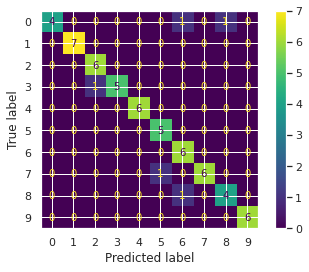

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the Random Forest Classifier
rf = RandomForestClassifier(random_state = 40)
rf.fit(train_features, y_train)

print(rf.score(test_features, y_test))

# Predict the labels for the test set
predictions = rf.predict(test_features)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Optionally, display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Output Summary

The output value of `0.9166666666666666` represents the accuracy of the Random Forest Classifier on the testing dataset, indicating that approximately **91.67%** of the predictions were correct.


By the confusion matrix We can observe that our model is predicting each class well.



### Conclusion

The objective of this project was to extract topological features from 3D images and train a model capable of classifying each handwritten digit.

Our results indicate that the 182 features we successfully extracted significantly enhance our ability to classify the data effectively.